In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
import keras
listOut=[]
for i in range(1000):
    X=np.zeros([28,28])
    X[np.random.randint(28),1]=1
    X[np.random.randint(28),27]=1
    A=distance_transform_edt(X==0)<10
    listOut.append(A)
#plt.imshow(A>10)
#plt.show()
plt.imshow(A)
plt.show()
plt.imshow(listOut[10])
plt.show()

Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
print(np.array(listOut).shape)
listOut=np.expand_dims(np.array(listOut),axis=3)*1
print(np.array(listOut).shape)
listOut = listOut.astype('float32')

(1000, 28, 28)
(1000, 28, 28, 1)


In [3]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 16
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 32
epsilon_std = 1.0
epochs = 50




In [4]:
#Decoder Model

output_shape = (batch_size, 14, 14, filters)
xdec = Input(shape=(latent_dim,),name='decoder_input')
dec_hid = Dense(intermediate_dim, activation='relu')(xdec)
dec_upsample = Dense(filters * 14 * 14, activation='relu')(dec_hid)
dec_reshape = Reshape(output_shape[1:])(dec_upsample)
dec_deconv_1 = Conv2DTranspose(filters,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu')(dec_reshape)
dec_deconv_1 = Conv2D(1,kernel_size=(1,1),padding='same',strides=(1,1),activation='relu')(dec_deconv_1)
Decoding= Model(xdec, outputs=dec_deconv_1)
Decoding.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              103488    
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         17        
Total params: 105,921
Trainable params: 105,921
Non-trainable params: 0
_________________________________________________________________


In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


    
#Encoder for Variational AutoEncoder 

x = Input(shape=original_img_size,name='main_input')
conv_1 = Conv2D(img_chns,kernel_size=(2, 2),padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu',strides=1)(conv_2)
conv_4 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu',strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
y = CustomVariationalLayer()([x, Decoding(z)])

vae=Model(x, y)
vae.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 1)    5           main_input[0][0]                 
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 16)   80          conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 16)   2320        conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

In [6]:
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

vae.fit(x=listOut, y=None,shuffle=True,epochs=250,batch_size=batch_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 1)    5           main_input[0][0]                 
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 16)   80          conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 16)   2320        conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

1000/1000 [==============================] - 1s 616us/step - loss: 0.2371
Epoch 61/250
1000/1000 [==============================] - 1s 608us/step - loss: 0.2336
Epoch 62/250
1000/1000 [==============================] - 1s 602us/step - loss: 0.2323
Epoch 63/250
1000/1000 [==============================] - 1s 612us/step - loss: 0.2365
Epoch 64/250
1000/1000 [==============================] - 1s 594us/step - loss: 0.2303
Epoch 65/250
1000/1000 [==============================] - 1s 602us/step - loss: 0.2263
Epoch 66/250
1000/1000 [==============================] - 1s 645us/step - loss: 0.2253
Epoch 67/250
1000/1000 [==============================] - 1s 602us/step - loss: 0.2282
Epoch 68/250
1000/1000 [==============================] - 1s 610us/step - loss: 0.2193
Epoch 69/250
1000/1000 [==============================] - 1s 619us/step - loss: 0.2177
Epoch 70/250
1000/1000 [==============================] - 1s 624us/step - loss: 0.2105
Epoch 71/250
1000/1000 [==============================] 

1000/1000 [==============================] - 1s 556us/step - loss: 0.1349
Epoch 154/250
1000/1000 [==============================] - 1s 565us/step - loss: 0.1304
Epoch 155/250
1000/1000 [==============================] - 1s 545us/step - loss: 0.1275
Epoch 156/250
1000/1000 [==============================] - 1s 563us/step - loss: 0.1253
Epoch 157/250
1000/1000 [==============================] - 1s 556us/step - loss: 0.1235
Epoch 158/250
1000/1000 [==============================] - 1s 553us/step - loss: 0.1222
Epoch 159/250
1000/1000 [==============================] - 1s 552us/step - loss: 0.1210
Epoch 160/250
1000/1000 [==============================] - 1s 543us/step - loss: 0.1205
Epoch 161/250
1000/1000 [==============================] - 1s 552us/step - loss: 0.1229
Epoch 162/250
1000/1000 [==============================] - 1s 550us/step - loss: 0.1218
Epoch 163/250
1000/1000 [==============================] - 1s 546us/step - loss: 0.1188
Epoch 164/250
1000/1000 [=====================

1000/1000 [==============================] - 1s 564us/step - loss: 0.1677
Epoch 247/250
1000/1000 [==============================] - 1s 565us/step - loss: 0.1627
Epoch 248/250
1000/1000 [==============================] - 1s 558us/step - loss: 0.1575
Epoch 249/250
1000/1000 [==============================] - 1s 556us/step - loss: 0.1529
Epoch 250/250
1000/1000 [==============================] - 1s 546us/step - loss: 0.1486


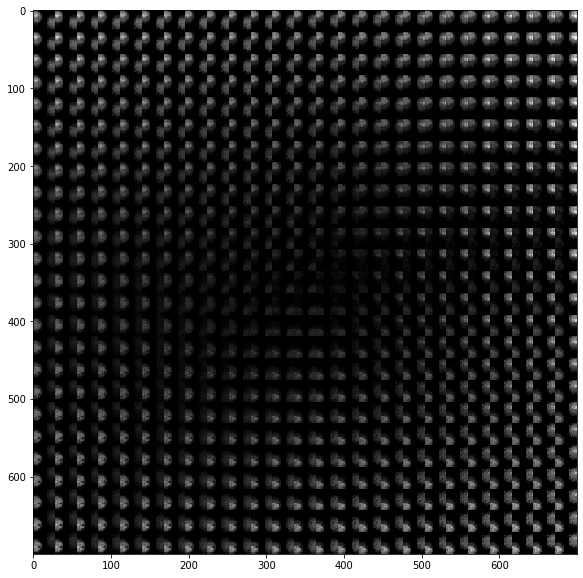

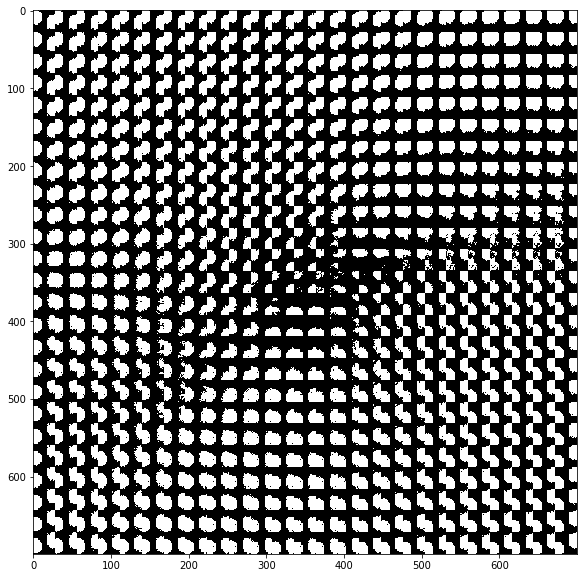

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 25
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = Decoding.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(figure>0.5, cmap='Greys_r')
plt.show()